# Combining the processed crop data

In [1]:
import os, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

In [2]:
#Rename and remove crops to simplify the number of subcrops
product_category_custom = {
    'Avocado (unspecified)':'Avocado',
    'Avocado (Hass)':'Avocado',
    'Banana (unspecified)':'Banana',
    'Bananas/Plantains, mixed':'Banana',
    'Beans (White)':'Beans',
    'Chick Peas':'Chickpea',
    'Kabuli chick pea':'Chickpea',
    'Gram':'Chickpea',
    'Hot red pepper':'Chili pepper',
    'Chili pepper (Unspecified)':'Chili pepper',
    'Cotton (Acala)':'Cotton',
    'Garlic (fresh)':'Garlic',
    'Groundnuts (In Shell)':'Groundnuts',
    'Macadamia (unspecified)':'Macadamia',
    'Maize (White)':'Maize',
    'Millet (Pearl)':'Millet',
    'Millet (Finger)':'Millet',
    'Mung bean':'Mung bean',
    'Mung bean (unspecified)':'Mung bean',
    'Pea (unspecified)':'Pea',
    'Potato (Irish)':'Potato',
    'Rice (Paddy)':'Rice',
    'Sorghum (Red)': 'Sorghum',
    'Taro (move to 1594AA)':'Taro',
    'Taro/Cocoyam':'Taro',
    'Cocoyam':'Taro'
}

#these subcrops will be removed. We keep white maize in South Africa to match the maize grown in the rest of the region
product_removal = [
    'Rice (not husked)',
    'Pepper (Piper spp.)',
    'Pam nut or kerna',
    'Maize (Yellow)',
    'Molokhia',
    'Spanish peanut',
    'Virginia peanut',
    'Groundnuts (In Shell, Large)',
    'Groundnuts (In Shell, Small)',
    'Cotton (Egyptian)',
    'Cottonseed',
    'Cotton (American)',
    'Cili pepper',
    'Gram (Green)',
    'Kabuli chick pea',
    'Cassava (non-bitter)',
    'Ethiopian cabbage',
    'Bean (Hyacinth)',
    'Beans (Pinto)',
    'Beans (Lima)',
    'Beans (Rosecoco)',
    'Green bean',
    'Bush bean',
    'Cooking Banana'
]

# some countries have 
country_specific_removal = {
    'ET':['Beans (mixed)','Beans (Red)'],
    'BJ':['Green pea'],
    'MZ':['Sweet Potatoes','Sweet Potatoes (Non-Orange)']
}

## Combine the processed crop data and shapefile

In [3]:
# Merge crop data
country_iso_list = [
    'AO','BF','BI','BJ','CD','CF','CM','ET','GN','KE','LR','LS','MG','ML','MR','MW','MZ',
    'NE','NG','RW','SD','SL','SN','SO','SS','TD','TG','TZ','UG','ZA','ZM','ZW',
    'AF','YE' # Afghanistan and Yemen will be excluded for the HarvestStat paper data
]
container = []
for country_iso in country_iso_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)

    # Remove some of the most minor crops
    df = df.loc[~(np.isin(df['product'],product_removal))]
    # Remove some country-specific products
    if np.isin(country_iso, country_specific_removal.keys()):
        df = df.loc[~(np.isin(df['product'],country_specific_removal[country_iso]))]
    # Change product name. This has to happen after removal of products
    df['product'] = df['product'].replace(product_category_custom)
    
    if 'QC_flag' in df.columns:
        df = df.drop(columns=['QC_flag'])

    cols_raw = df.columns
    cols = [
        'fnid', 'country', 'country_code', 'admin_1', 'admin_2', 'name',   
        'season_name', 'planting_year', 'planting_month',
        'harvest_year', 'harvest_month', 'crop_production_system', # 'QC_flag'
    ]
    area = df[df['indicator'] == 'area'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    prod = df[df['indicator'] == 'production'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    crop = prod/area
    area = area.stack().rename('value').reset_index()
    area['indicator'] = 'area'
    prod = prod.stack().rename('value').reset_index()
    prod['indicator'] = 'production'
    crop = crop.stack().rename('value').reset_index()
    crop['indicator'] = 'yield'
    df = pd.concat([area, prod, crop])[cols_raw]
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)

# Manual changes -------------------------------------------- #
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# ----------------------------------------------------------- #

# Merge the shapefiles used to process the crop data
path_dir = '../data/shapefile/fewsnet/'
shape_fn_list = []
# - Asia
shape_fn_list.append(os.path.join(path_dir, 'AF_Admin1_2017.shp')) # Afghanistan Admin1 in 2017
shape_fn_list.append(os.path.join(path_dir, 'YE_Admin1_2014.shp')) # Yemen Admin1 in 2014
# - East Africa
shape_fn_list.append(os.path.join(path_dir, 'BI_Admin1_1998.shp')) # Brundi Admin1 in 1998
shape_fn_list.append(os.path.join(path_dir, 'ET_Admin2_2019.shp')) # Ethiopia Admin2 in 2019
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2009.shp')) # Kenya Admin1 in 2009
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2013.shp')) # Kenya Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin1_1990.shp')) # Somalia Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin2_1990.shp')) # Somalia Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'MG_Admin2_2009.shp')) # Madagascar Admin2 in 2009
shape_fn_list.append(os.path.join(path_dir, 'MW_Admin2_2003.shp')) # Malawi Admin2 in 2003
shape_fn_list.append(os.path.join(path_dir, 'MZ_Admin1_2021.shp')) # Mozambique Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'RW_Admin2_2006.shp')) # Rwanda Admin2 in 2006
shape_fn_list.append(os.path.join(path_dir, 'SS_Admin2_2011.shp')) # South Sudan Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'TZ_Admin1_2012.shp')) # Tanzania Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'UG_Admin2_2007.shp')) # Uganda Admin2 in 2007
shape_fn_list.append(os.path.join(path_dir, 'ZM_Admin2_2011.shp')) # Zambia Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin1_2011.shp')) # Zimbabwe Admin1 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin2_2011.shp')) # Zimbabwe Admin2 in 2011
# - Central Africa
shape_fn_list.append(os.path.join(path_dir, 'AO_Admin1_2008.shp')) # Angola Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin1_2008.shp')) # Cameroon Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CF_Admin1_2003.shp')) # Central African Republic Admin1 in 2003
shape_fn_list.append(os.path.join(path_dir, 'TD_Admin1_2012.shp')) # Chad Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'CD_Admin1_2015.shp')) # DRC Admin1 in 2015
# - North Africa
shape_fn_list.append(os.path.join(path_dir, 'MR_Admin1_1990.shp')) # Mauritania Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SD_Admin1_2013.shp')) # Sudan Admin1 in 2013
# - West Africa
shape_fn_list.append(os.path.join(path_dir, 'BJ_Admin2_2015.shp')) # Benin Admin2 in 2015
shape_fn_list.append(os.path.join(path_dir, 'BF_Admin2_2001.shp')) # Burkina Faso Admin2 in 2001
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin2_2008.shp')) # Cameroon Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'GN_Admin2_1990.shp')) # Guinea Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'LR_Admin1_2008.shp')) # Liberia Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'ML_Admin1_2016.shp')) # Mali Admin1 in 2016
shape_fn_list.append(os.path.join(path_dir, 'NE_Admin2_2012.shp')) # Niger Admin2 in 2012
shape_fn_list.append(os.path.join(path_dir, 'NG_Admin1_1996.shp')) # Nigeria Admin1 in 1996
shape_fn_list.append(os.path.join(path_dir, 'SN_Admin2_2008.shp')) # Senegal Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'SL_Admin2_1960.shp')) # Sierra Leone Admin2 in 1960
# - Southern Africa
shape_fn_list.append(os.path.join(path_dir, 'LS_Admin1_1980.shp')) # Lesotho Admin1 in 1980
shape_fn_list.append(os.path.join(path_dir, 'ZA_Admin1_1994.shp')) # South Africa Admin1 in 1994
# Merge the shapefiles
shape = pd.concat([gpd.read_file(fn).to_crs(epsg=4326) for fn in shape_fn_list], axis=0).reset_index(drop=True)
shape['COUNTRY_ISO'] = shape['FNID'].apply(lambda x: x[:2])
shape = shape[['FNID','COUNTRY_ISO','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values('FNID').reset_index(drop=True)
# Manual correction
# Drop a row if FNID is "ZW2011A21503" and ADMIN2 is "Hwange Urban"
shape = shape[~((shape['FNID'] == 'ZW2011A21503') & (shape['ADMIN2'] == 'Hwange Urban'))]
assert len(shape['FNID'].unique()) == shape.shape[0]
# Reduce to designated countries
if True: shape = shape[shape['COUNTRY_ISO'].isin(country_iso_list)].reset_index(drop=True)
# Create country boundary (Admin0)
admin0 = shape.copy(deep=True)
admin0['ADMIN_CODE'] = admin0['FNID'].apply(lambda x: x[:8])
admin0 = admin0.to_crs(epsg=3857)
admin0['geometry'] = admin0['geometry'].buffer(200)
admin0 = admin0.dissolve(by='ADMIN_CODE')
admin0['geometry'] = admin0['geometry'].buffer(-200)
admin0 = admin0.loc[~admin0.index.isin(['KE2009A1','SO1990A1','ZW2011A1']),:]
admin0[['ADMIN1','ADMIN2']] = ''
admin0['FNID'] = admin0.index
admin0['FNID'] = admin0['FNID'].apply(lambda x: x[:-1]+'0')
admin0 = admin0.reset_index(drop=True)
admin0 = admin0.to_crs(epsg=4326)
# Merge
shape = pd.concat([admin0, shape], ignore_index=True).reset_index(drop=True)
shape = shape[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values(by=['FNID']).reset_index(drop=True)
# Change country_name
shape['ADMIN0'] = shape['ADMIN0'].replace({'Democratic Republic of the Congo': 'DRC'})

# Unstable version ------------------------------------------ #
fn_out = '../public/hvstat_data.csv'
df.to_csv(fn_out); print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
fn_out = '../public/hvstat_shape.gpkg'
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
shape_simplified.to_file(fn_out, driver='GPKG'); print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# ----------------------------------------------------------- #

../public/hvstat_data.csv is saved (57.00 MB).
../public/hvstat_shape.gpkg is saved (10.66 MB).


## Summary of "hvstat_data.csv"

In [4]:
shape = gpd.read_file('../public/hvstat_shape.gpkg')
shape = shape[shape['FNID'].apply(lambda x: x[-2:] != 'A0')].reset_index(drop=True)
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
df = df[['fnid','country','admin1','admin2','product','season','harvest_month','harvest_year','indicator','value']]
cps = df[['country','product','season']].drop_duplicates().reset_index(drop=True)
df['admin'] = df['fnid'].apply(lambda x: x[2:8])
table = pd.DataFrame(
    index=pd.MultiIndex.from_frame(df[['country','admin','season']].drop_duplicates()),
    columns= cps['product'].unique(),
    data = '-'
).rename_axis(columns='product')
for i, (country_name, product_name, season_name) in cps.iterrows():
    fnids_country = shape.loc[shape['ADMIN0'] == country_name, 'FNID']
    sub = df[
        (df['country'] == country_name) &
        (df['product'] == product_name) &
        (df['season'] == season_name) &
        (df['indicator'] == 'production')
    ]
    if sub.shape[0] > 0:
        count = sub.pivot_table(index='harvest_year', columns='fnid', values='value', aggfunc='count', fill_value=0)
        mean_count = count.sum().mean()
        string = '%d (%d/%d)' %  (mean_count, count.shape[1], len(fnids_country))
    else:
        string = '-'
    table.loc[pd.IndexSlice[country_name,:,season_name],product_name] = string
print('Mean record years (recorded districts / total districts)')
print(table.shape)
table

Mean record years (recorded districts / total districts)
(65, 137)


product                                                  Cassava       Maize  \
country                      admin  season                                     
Angola                       2008A1 Main              17 (18/18)  21 (18/18)   
Burundi                      1998A1 Season A          17 (16/17)  18 (16/17)   
                                    Season B          17 (16/17)  16 (16/17)   
                                    Season C          17 (16/17)  14 (15/17)   
Benin                        2015A2 Annual            26 (77/77)           -   
                                    Main                       -  26 (77/77)   
DRC                          2015A1 Main              10 (21/26)  10 (21/26)   
Central African Republic     2003A1 Main               3 (16/17)   3 (16/17)   
Cameroon                     2008A2 Annual             8 (56/68)   1 (33/68)   
                                    North 1st Season           -  10 (15/68)   
                                    North 2nd Season           -    6 (1/68)   
                                    1st Season                 -   6 (43/68)   
                                    2nd Season                 -   6 (35/68)   
Ethiopia                     2019A2 Meher                      -  15 (68/84)   
Guinea                       1990A2 Main               6 (33/34)   6 (31/34)   
Kenya                        2013A1 Annual             2 (43/55)  21 (46/55)   
                                    Long                       -  12 (47/55)   
                                    Short                      -   7 (45/55)   
Liberia                      2008A1 Main               7 (15/15)           -   
Lesotho                      1980A1 Summer                     -  39 (10/10)   
                                    Winter                     -    1 (3/10)   
Madagascar                   2009A2 Annual            28 (22/22)  28 (22/22)   
Mali                         2016A1 Main                       -   36 (8/11)   
Mauritania                   1990A1 Annual                     -    3 (7/13)   
                                    Bas-fond                   -   10 (9/13)   
                                    Dam retention              -    6 (6/13)   
                                    Main                       -    8 (7/13)   
                                    Hot off-season             -           -   
                                    Walo                       -   14 (4/13)   
                                    Cold off-season            -           -   
Mozambique                   2021A1 Annual            22 (10/11)           -   
                                    Cotton season              -           -   
                                    Main                       -  21 (10/11)   
                                    Rice season                -           -   
Niger                        2012A2 Main                3 (3/74)  11 (42/74)   
Nigeria                      1996A1 Annual            21 (37/37)           -   
                                    Wet                        -  22 (37/37)   
Rwanda                       2006A2 Season A           3 (30/30)   4 (30/30)   
                                    Season B           4 (30/30)   4 (30/30)   
                                    Season C                   -           -   
Sudan                        2013A1 Main                       -           -   
                                    Winter                     -           -   
Sierra Leone                 1960A2 Main               2 (13/14)   2 (13/14)   
Senegal                      2008A2 Main               7 (36/45)  35 (41/45)   
                                    Main-off                   -    6 (2/45)   
Somalia                      1990A2 Deyr                       -  21 (38/92)   
                                    Gu                         -  23 (38/92)   
                                    Deyr-off                   -   4 (27/92)   


## Map of processed countries

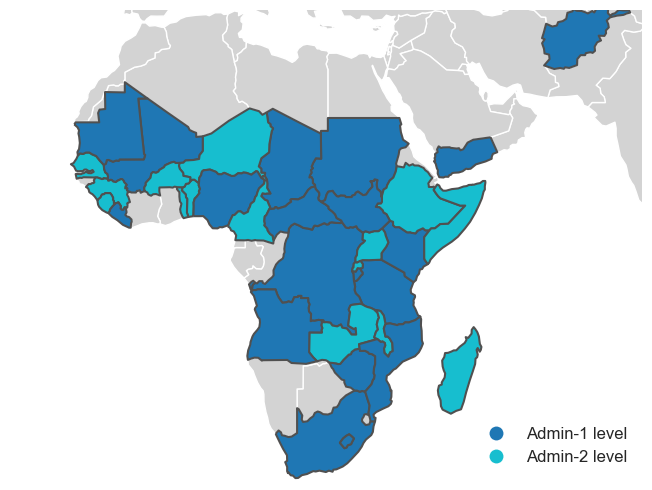

In [5]:
# Little touch on world boundary ---------------------------- #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
world.replace(
    {   'Tanzania':'Tanzania, United Republic of',
        'Dem. Rep. Congo':'DRC',
        'Central African Rep.': 'Central African Republic',
        'S. Sudan':'South Sudan',
    }, inplace=True
)
df = pd.read_csv('../public/hvstat_data.csv', index_col=0, low_memory=False)
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})

# Plotting
mapdata = map_processed.copy().to_crs('epsg:3857')
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis([-3087412, 8589989, -4174166, 4505999])
world.to_crs('epsg:3857').plot(ax=ax, color='lightgrey')
mapdata.plot(ax=ax, column='admin',linewidth=1.5, edgecolor='#505050', zorder=2,
            categorical=True, legend=True,
            legend_kwds={'loc': 'lower right', 'bbox_to_anchor':(1,0), 'frameon':False, 'fontsize':12},
)
plt.tight_layout()
fig.savefig('../docs/current_status_map.svg',pad_inches=0, bbox_inches='tight', transparent=False)

In [6]:
country_processed.groupby('admin')['country'].count()
# Group by admin level, and aggregate texts of each country. When grouping, sort countries by alphabet order.
country_list = country_processed.sort_values('country')
country_list = country_list.groupby('admin')['country'].apply(lambda x: ', '.join(x)).reset_index()
for i, row in country_list.iterrows():
    print('Admin', row['admin'], ':', sum(country_processed['admin'] == row['admin']), 'countries')
    print(row['country'])
    print('')

Admin 1 : 19 countries
Afghanistan, Angola, Burundi, Central African Republic, Chad, DRC, Kenya, Lesotho, Liberia, Mali, Mauritania, Mozambique, Nigeria, South Africa, South Sudan, Sudan, Tanzania, United Republic of, Yemen, Zimbabwe

Admin 2 : 15 countries
Benin, Burkina Faso, Cameroon, Ethiopia, Guinea, Madagascar, Malawi, Niger, Rwanda, Senegal, Sierra Leone, Somalia, Togo, Uganda, Zambia

